In [1]:
# General import 

import numpy as np
import scipy.sparse as sparse
import time
import matplotlib.pyplot as plt

In [2]:
# pyMPC import

from pyMPC.mpc import MPCController

## System dynamics ##

The system to be controlled is an inverted pendulum on a cart (see next Figure).  

<img src="img/cart_pole.png" width="250" align="center"/>

The system is governed by the following differential equations:

\begin{equation}
 \begin{aligned}
 (M+m)\ddot p + ml\ddot\phi \cos\phi - ml \dot \phi ^2 \sin \phi + b\dot p &= F \\
 l \ddot \phi + \ddot p \cos \phi - g \sin\phi &= -f_\phi\dot \phi
\end{aligned}
\end{equation}

Introducing the state vector $x=[p\; \dot p\; \phi\; \dot \phi]$ and the input $u=F$, the system dynamics are described in state-space by a set of an nonlinear ordinary differential equations: $\dot x = f(x,u)$ with

\begin{equation}
\begin{split}
  f(x,u) &= 
 \begin{bmatrix}
 x_2\\
 \frac{-mg \sin x_3\cos x_3 + mlx_4^3\sin x_3 + f_\phi m x_4 \cos x_3 - bx_2 + u }{M+(1-\cos^2 x_3)m}\\
 x_3\\
 \frac{(M+m)(g \sin x_3 - f_\phi x_4) - (lm x_4^2 \sin x_3 - bx_2 + u)\cos x_3}{l(M+(1-\cos^2 x_3)m)}
 \end{bmatrix}\\ 
 \end{split}
 \end{equation}

For MPC control design, the system is linearized about the upright (unstable) equilibrium point, i.e., about the point $x_{eq} = [0, \; 0\;, 0,\; 0]^\top$.
The linearized system has form $\dot  x =  A_c x + B_c u$ with

\begin{equation}
  A = 
 \begin{bmatrix}
 0& 1& 0& 0\\
 0& -\frac{b}{M}& -g\frac{m}{M}& f_\theta\frac{m}{M}\\
 0&0&0&1\\
 0&\frac{b}{Ml}& \frac{g(M+m)}{Ml}&-\frac{(M+m)f_\theta}{M l}
 \end{bmatrix},\qquad B= 
 \begin{bmatrix}
 0\\
 \frac{1}{M}\\
 0\\
 -\frac{1}{Ml}&
 \end{bmatrix}
 \end{equation}
 
Next, the system is discretized with sampling time $T_s = 0.50\;\text{ms}$. Here we just use Forward Euler integration for the sake of simplicity.


In [3]:
# MPC system matrices #

# Constants #
M = 0.5
m = 0.2
b = 0.1
ftheta = 0.1
l = 0.3
g = 9.81

Ts = 50e-3

# Continuous-time system matrices, linearized about the upright, unstable equilibrium point 
Ac =np.array([[0,       1,          0,                  0],
              [0,       -b/M,       -(g*m)/M,           (ftheta*m)/M],
              [0,       0,          0,                  1],
              [0,       b/(M*l),    (M*g + g*m)/(M*l),  -(M*ftheta + ftheta*m)/(M*l)]])

Bc = np.array([
    [0.0],
    [1.0/M],
    [0.0],
    [-1/(M*l)]
])

[nx, nu] = Bc.shape # number of states and number or inputs

# Brutal forward euler discretization
Ad = np.eye(nx) + Ac*Ts
Bd = Bc*Ts

In [4]:
# MPC reference input and states (set-points)

xref = np.array([0.3, 0.0, 0.0, 0.0]) # reference state
uref = np.array([0.0])    # reference input
uminus1 = np.array([0.0])     # input at time step negative one - used to penalize the first delta u at time instant 0. Could be the same as uref.

# Constraints
xmin = np.array([-100.0, -100, -100, -100])
xmax = np.array([100.0,   100.0, 100, 100])

umin = np.array([-20])
umax = np.array([20])

Dumin = np.array([-5])
Dumax = np.array([5])

In [5]:
# MPC constraints
xmin = np.array([-100.0, -100, -100, -100])
xmax = np.array([100.0,   100.0, 100, 100])

umin = np.array([-20])
umax = np.array([20])

Dumin = np.array([-5])
Dumax = np.array([5])

In [6]:
# MPC cosst function weights

Qx = sparse.diags([0.3, 0, 1.0, 0])   # Quadratic cost for states x0, x1, ..., x_N-1
QxN = sparse.diags([0.3, 0, 1.0, 0])  # Quadratic cost for xN
Qu = 0.0 * sparse.eye(1)        # Quadratic cost for u0, u1, ...., u_N-1
QDu = 0.01 * sparse.eye(1)       # Quadratic cost for Du0, Du1, ...., Du_N-1

In [7]:
# Initial state
phi0 = 15*2*np.pi/360
x0 = np.array([0, 0, phi0, 0]) # initial state

# Prediction horizon
Np = 20

In [8]:
# Initialize and setup MPC controller

K = MPCController(Ad,Bd,Np=20, x0=x0,xref=xref,uminus1=uminus1,
                  Qx=Qx, QxN=QxN, Qu=Qu,QDu=QDu,
                  xmin=xmin,xmax=xmax,umin=umin,umax=umax,Dumin=Dumin,Dumax=Dumax)
K.setup() # this initializes the QP problem for the first step

In [9]:
# Simulate in closed loop. Use MPC model as real system

# Simulate in closed loop
[nx, nu] = Bd.shape # number of states and number or inputs
len_sim = 10 # simulation length (s)
nsim = int(len_sim/Ts) # simulation length(timesteps)
xsim = np.zeros((nsim,nx))
usim = np.zeros((nsim,nu))
tsim = np.arange(0,nsim)*Ts

time_start = time.time()

xstep = x0
uMPC = uminus1
for i in range(nsim):
    xsim[i,:] = xstep

    # MPC update and step. Could be in just one function call
    K.update(xstep, uMPC) # update with measurement
    uMPC = K.step() # MPC step (u_k value)
    usim[i,:] = uMPC

    # System simulation
    F = uMPC
    v = xstep[1]
    theta = xstep[2]
    omega = xstep[3]
    der = np.zeros(nx)
    der[0] = v
    der[1] = (m*l*np.sin(theta)*omega**2 -m*g*np.sin(theta)*np.cos(theta)  + m*ftheta*np.cos(theta)*omega + F - b*v)/(M+m*(1-np.cos(theta)**2));
    der[2] = omega
    der[3] = ((M+m)*(g*np.sin(theta) - ftheta*omega) - m*l*omega**2*np.sin(theta)*np.cos(theta) -(F-b*v)*np.cos(theta))/(l*(M + m*(1-np.cos(theta)**2)) );
    # Forward euler step
    xstep = xstep + der*Ts

time_sim = time.time() - time_start


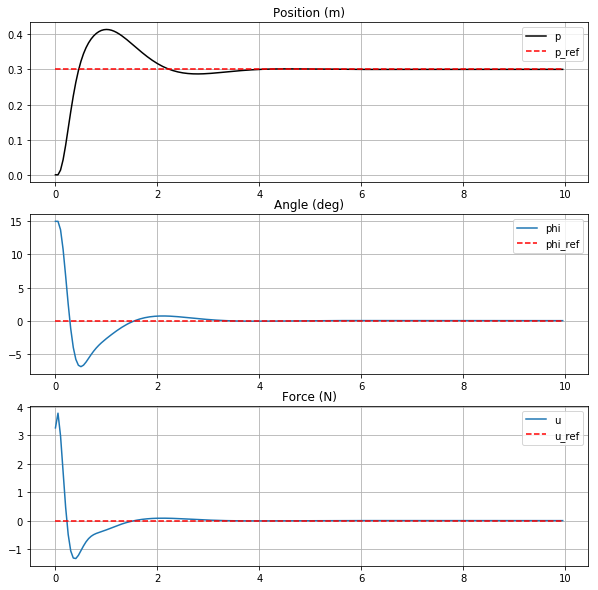

In [10]:
# Plot results

fig,axes = plt.subplots(3,1, figsize=(10,10))
axes[0].plot(tsim, xsim[:,0], "k", label='p')
axes[0].plot(tsim, xref[0]*np.ones(np.shape(tsim)), "r--", label="p_ref")
axes[0].set_title("Position (m)")

axes[1].plot(tsim, xsim[:,2]*360/2/np.pi, label="phi")
axes[1].plot(tsim, xref[2]*360/2/np.pi*np.ones(np.shape(tsim)), "r--", label="phi_ref")
axes[1].set_title("Angle (deg)")

axes[2].plot(tsim, usim[:,0], label="u")
axes[2].plot(tsim, uref*np.ones(np.shape(tsim)), "r--", label="u_ref")
axes[2].set_title("Force (N)")

for ax in axes:
    ax.grid(True)
    ax.legend()